In [1]:
import mdtraj as md
import pyemma.coordinates as coor
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gro = md.load('frame0_nw.gro')

In [3]:
traj = md.load('plpro_yrl_50_whole_wrap.trr', top=gro.top)

In [4]:
lig = gro.top.select('resname == yrl')
# 45 * 20
lig_idx = np.arange(0,900,20)

In [5]:
traj.superpose(gro, atom_indices=gro.top.select('backbone'))

<mdtraj.Trajectory with 30002 frames, 6118 atoms, 629 residues, and unitcells at 0x7fb890879bb0>

In [6]:
com_list = [0] * 45

for i in range(len(lig_idx)):
    small_traj = traj.atom_slice(lig[lig_idx[i]:lig_idx[i]+20])
    com_list[i] = md.compute_center_of_mass(small_traj)

In [7]:
import sklearn
from sklearn.cluster import DBSCAN

In [8]:
com_cat = np.concatenate(com_list)

In [9]:
cl = DBSCAN(eps=0.15, min_samples=6500).fit(com_cat)

In [10]:
len(set(cl.labels_))

1

In [11]:
def write_com_to_gro(com, file_name):
    ''' write center of mass point to gro file to open in VMD, chimera, or similiar'''
    with open(file_name, 'w') as f:
        f.write('Protein in water\n')
        f.write(' 1\n')
        f.write(f'    1GLU      N    1   {np.round(com[0], 3)}   {np.round(com[1], 3)}   {np.round(com[2], 3)}\n')
        f.write('  11.27360  11.27360  11.27360\n')

In [12]:
cluster_list = []
avg_list = []

for i in set(cl.labels_):
    if i == -1:
        continue
    cluster_list.append(com_cat[cl.labels_ == i])
    print(i, cluster_list[i].shape[0])
    avg_list.append(cluster_list[i].mean(axis=0))

In [13]:
crystal = md.load('../../true_7ofs.gro')

In [14]:
cry_idx = crystal.top.select('resname == yrl')
lig_rmsds = [0] * 45

In [15]:
def manual_rmsd(a,b):
    result = np.ndarray((a.shape[0],1), dtype='float32')
    N = b.shape[1]
    for i in range(a.shape[0]):
        result[i] = np.sqrt(np.sum((a[i] - b[0]) ** 2) / N)
    return result

def ex_rmsd(traj, ref, ref_frame=0, atom_indices_traj=None, atom_indices_ref=None, alignment_indices=None):
    'align to protein then take rmsd of ligand'
    traj.superpose(ref, frame=ref_frame, atom_indices=alignment_indices, parallel=True)
    small_traj = traj.atom_slice(atom_indices_traj)
    small_ref = ref.atom_slice(atom_indices_ref)
    f = manual_rmsd(small_traj.xyz, small_ref.xyz)
    return f

In [16]:
for i in range(len(lig_idx)):
    lig_rmsds[i] = ex_rmsd(traj, crystal, atom_indices_traj=lig[lig_idx[i]:lig_idx[i]+20], atom_indices_ref=cry_idx, alignment_indices=gro.top.select('backbone'))

In [17]:
time = np.arange(0, 300.02, 0.01)

In [22]:
under_9_list = [0] * 45
for i in range(len(lig_rmsds)):
    under_9_list[i] = (lig_rmsds[i] < 0.9).sum()

In [23]:
for i in range(len(under_9_list)):
    print(i, under_9_list[i])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 431
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 4
26 0
27 0
28 0
29 0
30 0
31 0
32 1
33 0
34 0
35 0
36 16
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 4


Text(0, 0.5, 'Ligand RMSD (nm)')

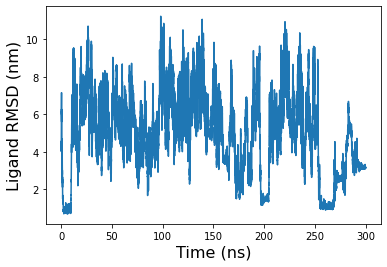

In [24]:
plt.plot(time, lig_rmsds[13])
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Ligand RMSD (nm)', fontsize=16)

In [25]:
np.save('lowest_lig_rmsd.npy', lig_rmsds[13])